<a href="https://colab.research.google.com/github/DhyeyShah794/poetry-analysis/blob/master/poetry_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn scikit-multilearn sentence-transformers contractions nltk wordcloud langdetect

In [2]:
!pip install git+https://github.com/cleanlab/cleanlab.git

  Cloning https://github.com/cleanlab/cleanlab.git to /tmp/pip-req-build-eou8becz
  Running command git clone --filter=blob:none --quiet https://github.com/cleanlab/cleanlab.git /tmp/pip-req-build-eou8becz
  Resolved https://github.com/cleanlab/cleanlab.git to commit 22dd845c48e53b3de6b70f9a9c93ed4f90288921
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cleanlab: filename=cleanlab-2.5.1-py3-none-any.whl size=314902 sha256=f988f3e4c0786728fe5f573ac2730d7dd5e4de97eedccea35e8129e17b42bf91
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qfm8dc8/wheels/3d/53/8f/09fde0499e2135d2566a50fe7afd0398373244187206c7d441
Successfully built cleanlab
  Attempting uninstall: termcolor
    Found existing installation: termcolor 2.4.0
    Uninstalling termcolor-2.4.0:
      Successfully uninstalled termcolor-2.4.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from langdetect import detect
import time
from ast import literal_eval
from sentence_transformers import SentenceTransformer, util
import unicodedata
import itertools
from collections import Counter
# from cleanlab import Datalab
import contractions
import nltk
from nltk.corpus import wordnet, stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, log_loss, f1_score, jaccard_score, hamming_loss
from sklearn.model_selection import cross_val_predict, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/DhyeyShah794/poetry-analysis/master/data.csv')

# Basic data exploration and cleaning

In [4]:
data.head()

,url,title,poem,categories
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,['acrostic']
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"['haiku', 'acrostic', 'humor']"
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,['acrostic']
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"['haiku', 'acrostic']"
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,['acrostic']


In [5]:
# Rename poem to poem_text to avoid future conflicts with label names
data.rename(columns={'poem': 'poem_text'}, inplace=True)

In [6]:
data.describe()

,url,title,poem_text,categories
count,63731,63158,63400,63731
unique,63731,58548,63205,25106
top,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,Graduation,I remember\nIt was the year\nThe grizzlies ran...,[]
freq,1,72,8,917


In [7]:
data.isnull().sum()

url             0
title         573
poem_text     331
categories      0
dtype: int64

In [8]:
# Remove those rows where the poem is empty or category values is an empty list
# Poems with no titles can also be used for analysis
data = data[data['poem_text'].notnull()]
data = data[~data['categories'].isin(['[]'])]

# Tokenization and lemmatization

In [9]:
def tokenize(column):
  cleaned = ' '.join([re.sub(r'[^\w\s]', '', contractions.fix(word).lower()) for word in column.split()])
  tokens = nltk.WhitespaceTokenizer().tokenize(cleaned)
  return [word for word in tokens if re.match(r'^[a-zA-Z]+$', word)]

In [10]:
data['tokenized'] = data['poem_text'].apply(lambda x: tokenize(x))

In [11]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [12]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def lemmatize_word(word, tag):
  if tag is None:
    return word
  else:
    return lemmatizer.lemmatize(word, tag)

In [14]:
def lemmatize_text(tokenized):
    pos_tagged = nltk.pos_tag(tokenized)
    lemmatized_tokens = [lemmatize_word(word, pos_tagger(tag)) for word, tag in pos_tagged]
    return " ".join(lemmatized_tokens)

In [15]:
data['lemmatized'] = data['tokenized'].apply(lambda x: lemmatize_text(x))

In [16]:
# If the lemmatized value is an empty string, it means there was no text in the Roman script
# We can safely discard such entries
data = data[data['lemmatized'].str.strip() != '']

In [17]:
data[data['lemmatized']=='']

,url,title,poem_text,categories,tokenized,lemmatized


In [18]:
# Languages like German, French, Spanish can still be misclassified as English
# So detect the language of each poem and then filter out everything other than English
data['language'] = data['poem_text'].apply(lambda x: detect(x))

In [19]:
print(data['language'].value_counts())

en    62189
fr       48
af       32
nl       30
tl       17
id       17
da       15
it       13
de       12
no       11
es       11
ro        8
et        7
ca        7
so        6
cy        5
pt        4
sv        4
sw        4
hi        4
hu        3
sl        3
sk        2
ru        2
lt        2
tr        2
hr        2
bg        2
pl        2
uk        2
ta        1
fi        1
vi        1
bn        1
lv        1
Name: language, dtype: int64


In [20]:
# Only consider those rows where the language is English, since it accounts for more than 95% of the dataset
data = data[data['language'] == 'en']

In [21]:
# Irrelevant data (random text entries and stuff)
indices_to_remove = data[data['url'].str.contains('Betweenkittensandriots')].index
data = data.drop(indices_to_remove)

In [22]:
# Convert category values from str to list
data['categories'] = data['categories'].apply(literal_eval)

In [23]:
def get_cat_freq():  # Returns a dict containing the frequency of each category
  cat_freq = {}
  for value in itertools.chain.from_iterable(data['categories']):
    cat_freq[value] = cat_freq.get(value, 0) + 1
  return cat_freq

In [24]:
cat_freq = get_cat_freq()
unique_cats = sorted((set(cat_freq.keys())))
print(len(unique_cats))
print(unique_cats)

232
['acrostic', 'africa', 'alone', 'america', 'angel', 'anger', 'animal', 'anniversary', 'april', 'august', 'autumn', 'baby', 'ballad', 'beach', 'beautiful', 'beauty', 'believe', 'bipolar', 'birth', 'brother', 'butterfly', 'candy', 'car', 'cat', 'change', 'chicago', 'child', 'childhood', 'children', 'chocolate', 'christian', 'christmas', 'cinderella', 'city', 'concrete', 'couplet', 'courage', 'crazy', 'culture', 'dance', 'dark', 'dark-humor', 'daughter', 'death', 'depression', 'despair', 'destiny', 'discrimination', 'dog', 'dream', 'education', 'elegy', 'epic', 'evil', 'fairy', 'faith', 'family', 'farewell', 'fate', 'father', 'fear', 'fire', 'fish', 'fishing', 'flower', 'fog', 'food', 'football', 'freedom', 'friend', 'frog', 'fun', 'funeral', 'funny', 'future', 'girl', 'god', 'golf', 'graduate', 'graduation', 'greed', 'green', 'grief', 'guitar', 'haiku', 'hair', 'happiness', 'happy', 'hate', 'heart', 'heaven', 'hero', 'history', 'holocaust', 'home', 'homework', 'honesty', 'hope', 'hor

In [25]:
n = 25
total_count = sum(cat_freq.values())

counter = Counter(cat_freq)
most_freq, least_freq = counter.most_common(n), counter.most_common()[:-n-1:-1]

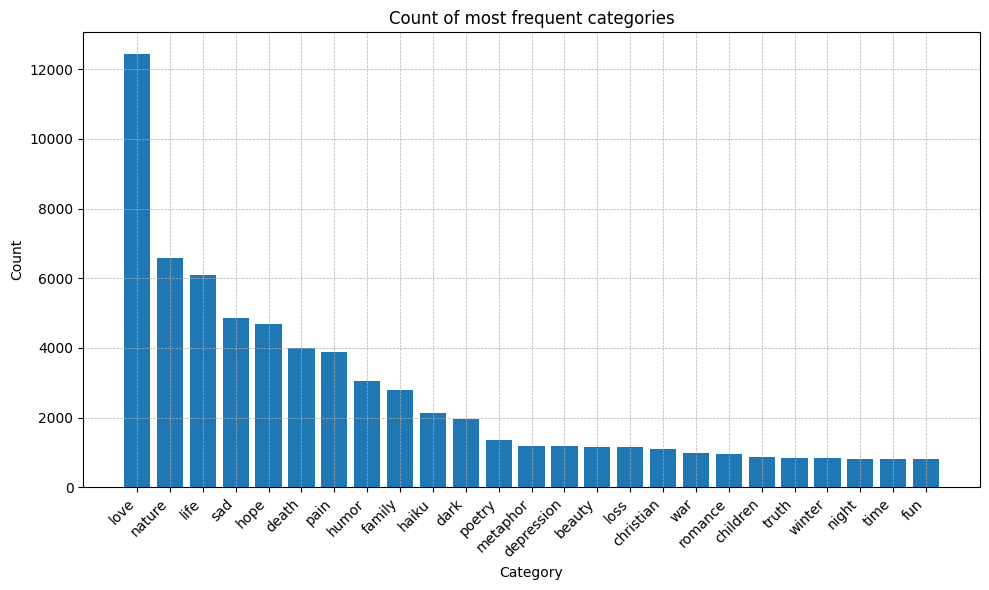

In [26]:
cats, counts = zip(*most_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of most frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

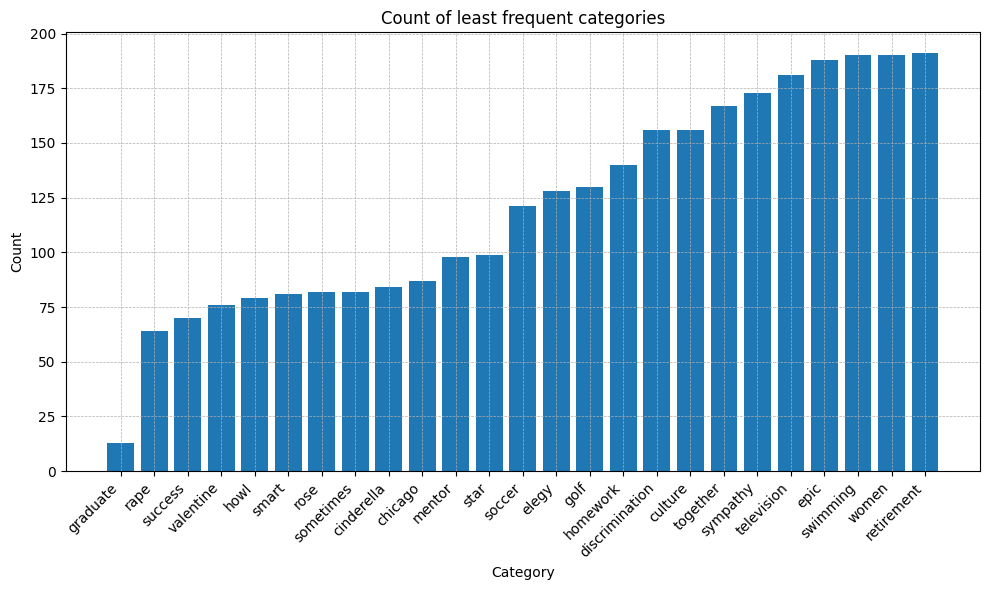

In [27]:
cats, counts = zip(*least_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of least frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of Poem Lengths')

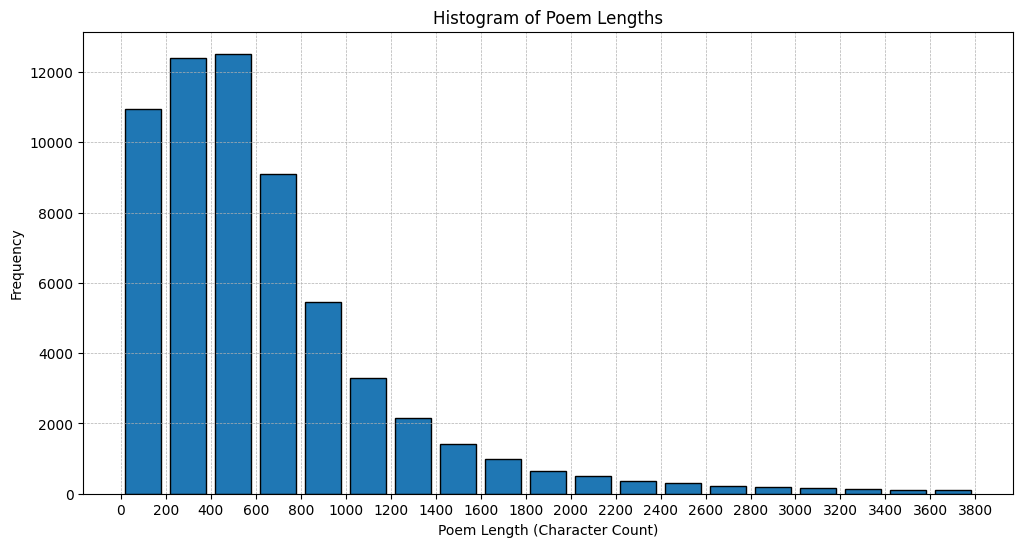

In [28]:
data['poem_length'] = data['poem_text'].apply(len)
intervals = [i * 200 for i in range(20)]

plt.figure(figsize=(12, 6))
plt.hist(data['poem_length'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(intervals)

plt.xlabel('Poem Length (Character Count)')
plt.ylabel('Frequency')
plt.title('Histogram of Poem Lengths')

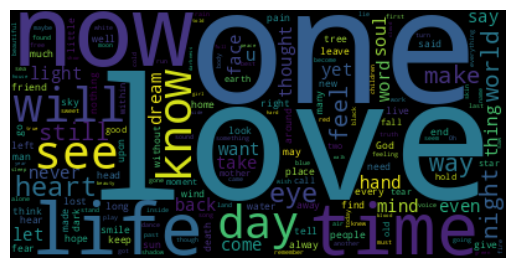

In [29]:
text = " ".join(poem for poem in data['poem_text'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png')
plt.show()

In [30]:
def word_count(text):
  words = re.findall(r'\w+', text)
  return len(words)

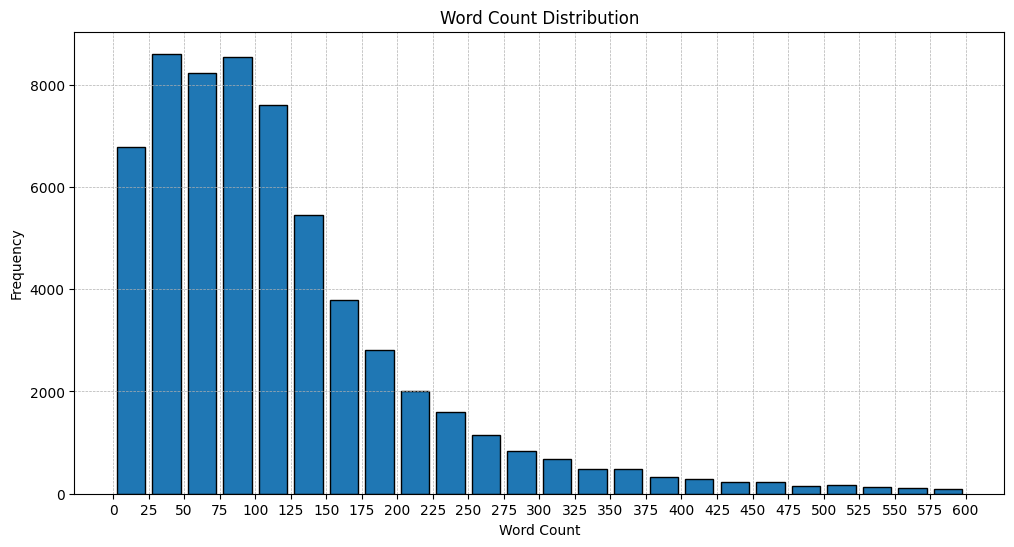

In [31]:
data['word_count'] = data['poem_text'].apply(word_count)
intervals = [i * 25 for i in range (25)]

plt.figure(figsize=(12, 6))
plt.hist(data['word_count'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.xticks(intervals)

plt.show()

# Combining semantically similar categories

In [32]:
# Optional code (to get similar categories using their cosine scores)

# model = SentenceTransformer('all-MiniLM-L6-v2')

# pairs = list(itertools.combinations(unique_cats, 2))
# cosine_scores = []

# for pair in pairs:
#   cat1 = pair[0]
#   cat2 = pair[1]

#   embeddings1 = model.encode(cat1)
#   embeddings2 = model.encode(cat2)

#   cosine_score = util.cos_sim(embeddings1, embeddings2)
#   cosine_scores.append(cosine_score.item())

# threshold = 0.7
# new = [(i, cosine_scores[i]) for i in range(len(cosine_scores)) if cosine_scores[i] >= threshold]
# similar_pairs = [pairs[value[0]] for value in new]

In [33]:
# The first item in each tuple to be replaced with the second item
cats_to_update = (
    ('children', 'child'),
    ('beautiful', 'beauty'),
    ('sunshine', 'sun'),
    ('sunset', 'sun'),
    ('mom', 'mother'),
    ('women', 'woman'),
    ('fishing', 'fish'),
    ('soccer', 'football'),
    ('graduate', 'graduation'),
    ('wedding', 'marriage'),
    ('ocean', 'sea'),
    ('poetry', 'poem'),
    ('romantic', 'romance'),
    )

In [34]:
def update_categories(old, new):
  # temp_obj = data['categories'].explode().replace(old, new)
  # temp_obj = temp_obj.to_frame().groupby(level=0).agg(list)
  # data['categories'] = temp_obj
  all_lists = data['categories'].to_list()
  for cat_list in all_lists:
    if old in cat_list and new not in cat_list:
      cat_list[cat_list.index(old)] = new
    elif (old, new) in cat_list:
      cat_list.remove(old)

In [35]:
for values in cats_to_update:
  update_categories(*values)

In [36]:
for old, new in cats_to_update:
  if old in get_cat_freq():
    print(old)
else:
  print("Categories updated successfully")

children
beautiful
sunshine
sunset
mom
women
fishing
soccer
graduate
wedding
ocean
poetry
romantic
Categories updated successfully


In [37]:
# Reassign updated values
cat_freq = get_cat_freq()
unique_cats = sorted((set(cat_freq.keys())))

# Vectorization

In [38]:
data.head()

,url,title,poem_text,categories,tokenized,lemmatized,language,poem_length,word_count
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,[acrostic],"[s, odden, ground, sounds, q, uenched, earth, ...",s odden grind sound q uenched earth belch you ...,en,173,34
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"[haiku, acrostic, humor]","[hair, under, my, rim, appalling, mind, below,...",hair under my rim appalling mind below me the ...,en,63,13
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,[acrostic],"[a, ka, tammuz, ancient, hearttrob, canaanite,...",a ka tammuz ancient hearttrob canaanite yoof t...,en,510,88
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"[haiku, acrostic]","[i, strive, and, slave, and, will, characters,...",i strive and slave and will character onto scr...,en,230,42
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,[acrostic],"[wandas, orgasmic, antique, hatstand, wolfgang...",wandas orgasmic antique hatstand wolfgangs orr...,en,147,20


In [39]:
# To avoid imbalance between classes, we define a minimum threshold of n = 1% of the total data items
# If a category has fewer than n samples, we do not consider it for training

n = 0.03 * data.shape[0]
filtered_cat_freq = {k: v for k, v in cat_freq.items() if v >= n}
discarded = list(set(unique_cats) - (set(filtered_cat_freq.keys())))

In [40]:
print(f"Filtered {len(filtered_cat_freq)} categories")
print(f"Discarded {len(discarded)} categories")

if set(filtered_cat_freq).intersection(set(discarded)) == set():
  print("No overlaps found")

Filtered 12 categories
Discarded 220 categories
No overlaps found


In [41]:
def remove_category(cat):
  all_lists = data['categories'].to_list()
  for cat_list in all_lists:
    if cat in cat_list:
      cat_list.remove(cat)

In [42]:
# MultiLabelBinarizer creates new columns from the dataset directly
# Need to remove all instances of the discarded categories from 'categories'

start = time.time()
for cat in discarded:
  remove_category(cat)
print(time.time() - start)

1.4069325923919678


In [43]:
cat_freq = get_cat_freq()
unique_cats = sorted((set(cat_freq.keys())))

In [44]:
# Remove rows with empty categories list (due to the above removal)
data = data[data['categories'].str.len() != 0]

In [45]:
data.shape

(34656, 9)

In [46]:
print(f"Pre-vectorization column count: {len(data.columns)}")

Pre-vectorization column count: 9


In [47]:
data.head()

,url,title,poem_text,categories,tokenized,lemmatized,language,poem_length,word_count
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"[haiku, humor]","[hair, under, my, rim, appalling, mind, below,...",hair under my rim appalling mind below me the ...,en,63,13
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,[haiku],"[i, strive, and, slave, and, will, characters,...",i strive and slave and will character onto scr...,en,230,42
6,https://allpoetry.com/poem/17490821-The-Job-Se...,The Job Search,Under fluorescents\nNervousness knits\nI have ...,[hope],"[under, fluorescents, nervousness, knits, i, h...",under fluorescent nervousness knit i have the ...,en,200,34
7,https://allpoetry.com/poem/17490034-Grief--Acr...,Grief (Acrostic),"Grief greatly groans, grappling injustice\nR...",[pain],"[grief, greatly, groans, grappling, injustice,...",grief greatly groan grappling injustice rain t...,en,225,30
8,https://allpoetry.com/poem/17488484-Nebraska--...,Nebraska (Acrostic Poem),New days blossom with blessings\nEarly blazing...,[nature],"[new, days, blossom, with, blessings, early, b...",new day blossom with blessing early blaze sunr...,en,271,42


In [48]:
mlb = MultiLabelBinarizer()

In [49]:
data = data.join(pd.DataFrame(mlb.fit_transform(data['categories']), index=data.index, columns=mlb.classes_))

In [50]:
print(f"Post-vectorization column count: {len(data.columns)}")

Post-vectorization column count: 21


In [51]:
new_cats = list(mlb.classes_)
print(new_cats)

['dark', 'death', 'family', 'haiku', 'hope', 'humor', 'life', 'love', 'nature', 'pain', 'poem', 'sad']


In [52]:
# Check whether any discarded category is present in the column names list
if set(new_cats).intersection(set(discarded)) == set():
  print("None of the discarded categories were vectorized")

None of the discarded categories were vectorized


In [53]:
data.head()

,url,title,poem_text,categories,tokenized,lemmatized,language,poem_length,word_count,dark,...,family,haiku,hope,humor,life,love,nature,pain,poem,sad
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"[haiku, humor]","[hair, under, my, rim, appalling, mind, below,...",hair under my rim appalling mind below me the ...,en,63,13,0,...,0,1,0,1,0,0,0,0,0,0
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,[haiku],"[i, strive, and, slave, and, will, characters,...",i strive and slave and will character onto scr...,en,230,42,0,...,0,1,0,0,0,0,0,0,0,0
6,https://allpoetry.com/poem/17490821-The-Job-Se...,The Job Search,Under fluorescents\nNervousness knits\nI have ...,[hope],"[under, fluorescents, nervousness, knits, i, h...",under fluorescent nervousness knit i have the ...,en,200,34,0,...,0,0,1,0,0,0,0,0,0,0
7,https://allpoetry.com/poem/17490034-Grief--Acr...,Grief (Acrostic),"Grief greatly groans, grappling injustice\nR...",[pain],"[grief, greatly, groans, grappling, injustice,...",grief greatly groan grappling injustice rain t...,en,225,30,0,...,0,0,0,0,0,0,0,1,0,0
8,https://allpoetry.com/poem/17488484-Nebraska--...,Nebraska (Acrostic Poem),New days blossom with blessings\nEarly blazing...,[nature],"[new, days, blossom, with, blessings, early, b...",new day blossom with blessing early blaze sunr...,en,271,42,0,...,0,0,0,0,0,0,1,0,0,0


In [54]:
# Check if the vectorized values are correct
data[data['url'] == 'https://allpoetry.com/poem/17490034-Grief--Acrostic---by-Mrs-Campbell-noguest']['pain']

7    1
Name: pain, dtype: int64

In [55]:
data[data['url'] == 'https://allpoetry.com/poem/17422719-kis-by-Filmschool']['love']

63727    1
Name: love, dtype: int64

# Model Training
## In progress, need to try other techniques and parameter values too

In [ ]:
# k = 5
# metrics = ['f1_macro', 'jaccard_macro']
# NB_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
#  ('clf', OneVsRestClassifier(MultinomialNB(
#      fit_prior=True, class_prior=None))),])

# scores = cross_validate(NB_pipeline, data['lemmatized'], data[new_cats], cv=k, scoring=metrics)

In [ ]:
# print('Mean F1-score across folds:', scores['test_f1_macro'].mean())
# print('Mean Jaccard similarity across folds:', scores['test_jaccard_macro'].mean())

In [100]:
# X = data.iloc[:, :6]

In [56]:
data.shape

(34656, 21)

In [57]:
# X = X.drop(columns=['categories'])
X = data.lemmatized
X.shape

(34656,)

In [58]:
y = data.iloc[:, 9:]
y.head()

,dark,death,family,haiku,hope,humor,life,love,nature,pain,poem,sad
1,0,0,0,1,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True)

In [107]:
X_train.head()

23188    hark hark hear ye that the silence overbear he...
47082    i behold an afternoon rainbow she ease into my...
57784    the distance be winter that be endure hug the ...
9080     i walk silently along the smooth sand of the b...
55093    i sit alone and watch the sea crash cry out fo...
Name: lemmatized, dtype: object

In [108]:
X_test.head()

52208    i visit my sister wall daily nightly if i be f...
26663    bubble the gold fish my teacher bubble the dou...
30520    there be a promise of tomorrow in colorful vig...
10975    metropolis describes my mind when everythings ...
5384     find beauty in a picture which depict an unhap...
Name: lemmatized, dtype: object

In [109]:
y_train.head()

,dark,death,family,haiku,hope,humor,life,love,nature,pain,poem,sad
23188,0,0,0,0,0,1,0,0,0,0,0,0
47082,0,0,0,0,0,0,0,0,1,0,0,0
57784,0,0,0,0,0,0,0,1,0,0,0,0
9080,0,1,1,0,1,0,0,0,0,1,0,1
55093,0,1,0,0,0,0,0,0,0,0,0,1


In [110]:
y_test.head()

,dark,death,family,haiku,hope,humor,life,love,nature,pain,poem,sad
52208,0,0,0,0,0,0,0,1,0,1,0,1
26663,0,0,0,1,0,0,1,0,0,0,0,0
30520,0,0,0,0,1,0,0,0,1,0,0,0
10975,0,0,0,0,0,0,0,0,1,0,0,0
5384,0,0,0,0,1,0,0,0,0,0,0,0


In [59]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.naive_bayes import MultinomialNB

In [60]:
binary_rel_clf = BinaryRelevance(MultinomialNB())

In [61]:
tfidf = TfidfVectorizer()

In [62]:
X_features = tfidf.fit_transform(X).toarray()

In [63]:
X_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, random_state=42, test_size=0.3, shuffle=True)

In [117]:
print(y_train.dtypes)

dark      int64
death     int64
family    int64
haiku     int64
hope      int64
humor     int64
life      int64
love      int64
nature    int64
pain      int64
poem      int64
sad       int64
dtype: object


In [116]:
binary_rel_clf.fit(X_train, y_train)

TypeError: no supported conversion for types: (dtype('O'),)

In [ ]:
# X_train = train.lemmatized
# X_test = test.lemmatized
# print(X_train.shape)
# print(X_test.shape)

(24263,)
(10399,)


In [ ]:
# NB_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
#  ('clf', OneVsRestClassifier(MultinomialNB(
#      fit_prior=True, class_prior=None))),])

In [ ]:
# acc_list = []
# prec_list = []
# for category in sorted(new_cats):
#     NB_pipeline.fit(X_train, train[category])
#     prediction = NB_pipeline.predict(X_test)
#     acc_score = accuracy_score(test[category], prediction)
#     prec_score = precision_score(test[category], prediction)
#     acc_list.append(acc_score)
#     prec_list.append(prec_score)
#     print(f"{category}: Test accuracy = {acc_score}\tTest precision: {prec_score}")

In [ ]:
# print(f'Mean accuracy: {np.mean(acc_list)}')
# print(f'Mean precision: {np.mean(prec_list)}')
# Mean accuracy: 0.870761217948718
# Mean precision: 0.31479494515975204

In [ ]:
RF_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

In [ ]:
acc_list = []
prec_list = []
for category in sorted(new_cats):
    RF_pipeline.fit(X_train, train[category])
    prediction = RF_pipeline.predict(X_test)
    acc_score = accuracy_score(test[category], prediction)
    prec_score = precision_score(test[category], prediction)
    acc_list.append(acc_score)
    prec_list.append(prec_score)
    print(f"{category}: Test accuracy = {acc_score}\tTest precision: {prec_score}")

dark: Test accuracy = 0.9425906337147802	Test precision: 0.6666666666666666
death: Test accuracy = 0.879219155688047	Test precision: 0.8888888888888888
family: Test accuracy = 0.9172035772670449	Test precision: 0.7777777777777778
haiku: Test accuracy = 0.9492258871045293	Test precision: 0.8284023668639053
hope: Test accuracy = 0.8632560823156072	Test precision: 0.75
humor: Test accuracy = 0.9122030964515819	Test precision: 0.0
life: Test accuracy = 0.8261371285700548	Test precision: 0.7368421052631579
love: Test accuracy = 0.7352630060582749	Test precision: 0.8134422110552764
nature: Test accuracy = 0.8245023559957688	Test precision: 0.7707006369426752
pain: Test accuracy = 0.8855659197999808	Test precision: 1.0
poem: Test accuracy = 0.9431676122704106	Test precision: 1.0
sad: Test accuracy = 0.8563323396480431	Test precision: 0.6666666666666666


In [ ]:
print(f'Mean accuracy: {np.mean(acc_list)}')
print(f'Mean precision: {np.mean(prec_list)}')

Mean accuracy: 0.8778888995736769
Mean precision: 0.7416156100104178


In [ ]:
# LogReg_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer()),
#                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
#             ])

In [ ]:
# acc_list = []
# prec_list = []
# for category in new_cats:
#     LogReg_pipeline.fit(X_train, train[category])
#     prediction = LogReg_pipeline.predict(X_test)
#     acc_score = accuracy_score(test[category], prediction)
#     prec_score = precision_score(test[category], prediction)
#     acc_list.append(acc_score)
#     prec_list.append(prec_score)
#     print(f"{category}: Test accuracy = {acc_score}\tTest precision: {prec_score}")

In [ ]:
# print(f'Mean accuracy: {np.mean(acc_list)}')
# print(f'Mean precision: {np.mean(prec_list)}')
# Mean accuracy: 0.8859054487179487
# Mean precision: 0.6401228220134808

In [5]:
import pickle
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: Save the model using pickle.dump


pickle.dump(RF_pipeline, open('/content/drive/My Drive/poetry_classifier.sav', 'wb'))


In [6]:
loaded_model = pickle.load(open('/content/drive/My Drive/poetry_classifier.sav', 'rb'))

In [7]:
data.head()

,url,title,poem,categories
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,['acrostic']
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"['haiku', 'acrostic', 'humor']"
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,['acrostic']
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"['haiku', 'acrostic']"
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,['acrostic']


In [34]:
test_poem = """
And maybe I'll never have a

Candlelight dinner with
A sweet
Lover under the miserable
Moon.

Blue insides paled at the
End of our tale it was a
Tuesday (or possibly Saturday) afternoon.
Rainbow boyfriends discussed
And you were filled with disgust
You were horrified and heartbroken too
At my betrayal of trust I made years before we were 'us'
Lifeless connection is dust, and we're through.
"""

In [35]:
test_poem = pd.Series(test_poem)
test_poem = test_poem.apply(lambda x: tokenize(x))
test_poem = test_poem.apply(lambda x: lemmatize_text(x))[0]

In [37]:
# loaded_model.predict([test_poem])

array([[0.32, 0.68]])

In [38]:
loaded_model.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()),
  ('clf', OneVsRestClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'clf': OneVsRestClassifier(estimator=RandomForestClassifier()),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'clf__estimator__bootstrap': True,
 'clf__estimator__ccp_alpha': 0.0,
 'clf__estimator__class_weight': None,
 'clf__estimator__criterion': 'gini',
 'clf__e

# Experimenting with cleanlab

In [ ]:
# new = data.copy()
# new.drop(new.index[-60_000:], inplace=True)
# new.shape

In [ ]:
raw_texts, labels, urls = data["poem"].values, data["categories"].values, data["url"].values
num_classes = len(set(labels))

print(f"This dataset has {num_classes} classes.")
print(f"Classes: {set(labels)}")

This dataset has 25036 classes.
Classes: {'romance,love,butterfly', 'horse,animal,humor,nature,love', 'marriage,life,suicide,death', 'beauty,happiness,family', 'discrimination,world,racism,prejudice', 'pink,dance', 'fear,song,hope', 'lgbtq,thanks,love', 'hope,faith,war', 'people,world,water', 'school,teacher,summer,humor', 'love,valentine,future', 'sunset,nature,autumn', 'despair,world,crazy', 'loss,hope,grief,death,family,son', 'moon,music,night', 'love,humor,hope,peace,family', 'sad,love,friend,lost', 'hair,night', 'sad,butterfly', 'beauty,fire,love,hope', 'pain,love,poem,time', 'racism,daughter,family', 'swimming,alone', 'poetry,anniversary', 'love,acrostic,joy,life', 'pain,loss,sad,sister,death,family', 'travel,respect', 'love,hate,grief,family,sorrow', 'passion,inspiration,music,night,chocolate', 'innocence,war', 'song,humor,children,music,candy', 'greed,death,grief', 'honesty,pain,journey,hope', 'love,metaphor,sleep', 'night,purple,nature', 'dark,night,snake,life,pride', 'love,ep

In [ ]:
transformer = SentenceTransformer('google/electra-small-discriminator')
text_embeddings = transformer.encode(raw_texts)

In [ ]:
model = LogisticRegression(max_iter=400)

pred_probs = cross_val_predict(model, text_embeddings, labels, method="predict_proba")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
data_dict = {"texts": raw_texts, "labels": labels}

In [ ]:
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=text_embeddings)

In [ ]:
lab.report()

In [ ]:
for i in [1619, 1668, 2333, 2337, 2255, 2398]:
  print(f"URL: {urls[i]}")
  print(f"Category: {labels[i]}")
  print(f"Poem: {raw_texts[i][:50]}")

URL: https://allpoetry.com/poem/16395872-An-Angel-Can-Fall-From-Above-by-Katrine-K%C3%A6rsvang
Category: christian,angel,pain,love
Poem: An angel can find you
in a sadden dwell
A bond she
URL: https://allpoetry.com/poem/16161285-An-angel-can-fall-from-above-by-AngelicKatrine
Category: god,angel,sad,love
Poem: An angel can find you
in a sadden dwell
A bond she
URL: https://allpoetry.com/poem/16831008-The-stones-are-my-mind-by-Eyewind--by-Eyewind
Category: metaphor,animal
Poem: Rocks are like the waves of the sea
They are wave 
URL: https://allpoetry.com/poem/16824865-The-stones-are-my-mind-by-Eyewind-by-Eyewind
Category: metaphor,fire,animal
Poem: Rocks are like the waves of the sea
They are wave 
URL: https://allpoetry.com/poem/14244434-A-Native-of-Florida-s-Reefs----Fishing--by-Dr.Ram-Mehta
Category: animal
Poem: I am the native of the Florida Keys and Bahamas
Pe
URL: https://allpoetry.com/poem/16667594-A-Native-of-Florida-s-Reefs----Animal--by-Dr.Ram-Mehta
Category: animal
Poem: I am